<a href="https://colab.research.google.com/github/Nikhild1093/Nikhild1093/blob/main/Neural%20Networks/Dog_vs_Cat_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonytherrien/dog-vs-cat")

print("Path to dataset files:", path)

100%|██████████| 360M/360M [00:02<00:00, 183MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3


In [2]:
import os
cat_path, cat_dirs, cat_files = next(os.walk('/root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals/cat'))
dog_path, dog_dirs, dog_files = next(os.walk('/root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals/dog'))

In [3]:
print(len(cat_files))
print(len(dog_files))

500
500


In [4]:
cat_path

'/root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals/cat'

Print name of images

In [5]:
cat_file_names = os.listdir(cat_path)
cat_file_names[1]

'00009-4122619882.png'

In [6]:
dog_file_names = os.listdir(dog_path)
dog_file_names[1]

'00862-3846169024.png'

Dependencies

In [7]:
from IPython.core.formatters import PlainTextFormatter
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

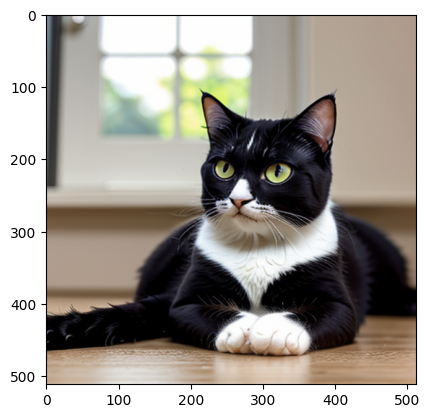

In [8]:
#display dog image
img = mpimg.imread('/root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals/cat/00009-4122619882.png')
imgplt = plt.imshow(img)

Resize all the images

In [9]:
#Create a directory for resized images
os.mkdir('/content/cat image resized')
os.mkdir('/content/dog image resized')

In [10]:
resized_folder = '/content/cat image resized/'

for i in range(500):
  img_path = os.path.join(cat_path, cat_file_names[i])
  img = Image.open(img_path)
  img = img.resize((224,224))
  img = img.convert('RGB')
  new_path = resized_folder+cat_file_names[i]
  img.save(new_path)

In [11]:
resized_folder = '/content/dog image resized/'

for i in range(500):
  img_path = os.path.join(dog_path, dog_file_names[i])
  img = Image.open(img_path)
  img = img.resize((224,224))
  img = img.convert('RGB')
  new_path = resized_folder+dog_file_names[i]
  img.save(new_path)

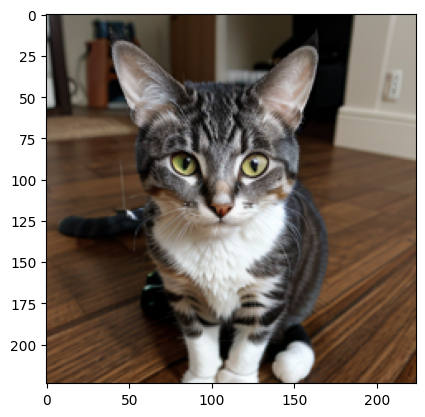

In [12]:
#Display resized image
img = mpimg.imread('/content/cat image resized/00000-4122619873.png')
plt.imshow(img)

Creating labels (Dog/Cat) for resized images

In [21]:
labels = [1] * 500 + [0] * 500
print(len(labels))
print(labels[:10]) # Display first 10 elements
print(labels[-10:]) # Display last 10 elements

1000
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
import cv2
import glob

dog_path = '/content/dog image resized/'
cat_path = '/content/cat image resized/'
files = []
[files.extend(glob.glob(dog_path+'*.png'))]
[files.extend(glob.glob(cat_path+'*.png'))]

dog_cat_images = np.asarray([cv2.imread(f) for f in files])

In [30]:
dog_cat_images.shape

(1000, 224, 224, 3)

In [34]:
#scale the data
dog_cat_images_sc = dog_cat_images/255

Feature Selection

In [35]:
X = dog_cat_images_sc
Y = np.asarray(labels)

In [36]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2, random_state = 1)

Building NN

In [38]:
import tensorflow as tf
import tensorflow_hub as hub

In [48]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load the MobileNetV2 model pre-trained on ImageNet
# Exclude the top classification layer to use it as a feature extractor
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the convolutional base to prevent its weights from being updated during training
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [49]:
num_classes = 2

inputs = tf.keras.Input(shape=(224, 224, 3))
# Use the frozen base_model (feature extractor)
x = base_model(inputs, training=False) # Set training=False to ensure base_model runs in inference mode
x = GlobalAveragePooling2D()(x) # Flatten the feature maps
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [50]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [52]:
model.fit(xtrain,ytrain,epochs=5)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.8325 - loss: 0.3781
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.9985 - loss: 0.0105
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 1.0000 - loss: 0.0053
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - acc: 1.0000 - loss: 0.0042
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - acc: 1.0000 - loss: 0.0038


In [54]:
score,acc = model.evaluate(xtest,ytest)
print('Test Loss = ',score)
print('Test Accuracy= ',acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 1.0000 - loss: 0.0027
Test Loss =  0.0023999535478651524
Test Accuracy=  1.0


Predictive System

Path of image: /content/dog.jpg


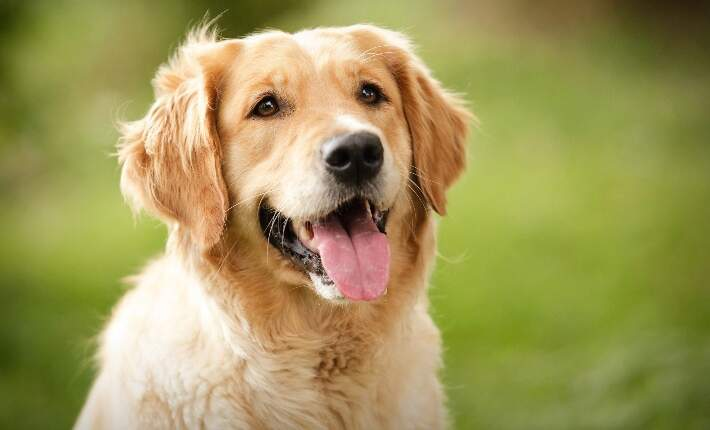

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
[[-1.4421145  2.3977818]]
Dog


In [62]:
in_img_path = input('Path of image: ')
in_img = cv2.imread(in_img_path)
cv2_imshow(in_img)
img_resize = cv2.resize(in_img,(224,224))
in_img_sc = img_resize/255
img_reshaped = np.reshape(in_img_sc,[1,224,224,3])
pred = model.predict(img_reshaped)
print(pred)
pred_label = np.argmax(pred)

if pred_label ==0:
  print('Cat')

else:
  print('Dog')